In [6]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

ds=xr.load_dataset("../results_stacked_hh.nc")

FileNotFoundError: [Errno 2] No such file or directory: '/home/ntion/A1_projects/flow-meta-api/model_error_database/results_stacked_hh.nc'

Behaviour between samples and power biases for a given case

In [ ]:
# sample_idx = 153  # Change this to any integer from 0 to 999

# # Extract the power_bias_perc for this sample across all case_index
# bias = ds.power_bias_perc.isel(sample=sample_idx).values

# # Optionally, get wind_farm or flow_case labels for x-axis
# wind_farms = ds.wind_farm.values
# flow_cases = ds.flow_case.values

# plt.figure(figsize=(12, 5))
# plt.plot(bias, marker='o')
# plt.xlabel('case_index')
# plt.ylabel('power_bias_perc')
# plt.title(f'Power Bias (%) for Sample {sample_idx}\nk_b={ds.k_b[sample_idx].item():.4f}, ss_alpha={ds.ss_alpha[sample_idx].item():.3f}')
# plt.grid(True)
# plt.show()

ad-hoc parameter fitting to minimize MSE over each case

In [ ]:
"""
taking bias values for all cases for this sample
finding mse of bias
selecting the best sample to minimize mse

"""
bias_array = ds.power_bias_perc.values  # (nsamples, nflowcases)

# Compute MSE for each sample (mean squared bias across all cases)
mses = np.mean(bias_array**2, axis=1)

# Find the sample with lowest MSE
best_idx = np.argmin(mses)
best_kb = ds.k_b.values[best_idx]
best_alpha = ds.ss_alpha.values[best_idx]

print(f"Best sample index: {best_idx}, k_b: {best_kb:.4f}, ss_alpha: {best_alpha:.4f}")

ds_best_sample=ds.isel(sample=best_idx)


Best sample index: 153, k_b: 0.0222, ss_alpha: 0.8669


adjusting dataset with features and targets and scaling features

In [ ]:
ds_best_sample=ds.isel(sample=best_idx)#.reset_coords(drop=True)

df=ds_best_sample.to_dataframe().reset_index()
df['log_z0']=np.log(df['z0'].values)

features = df.drop(['wind_farm', 'flow_case','sample', 'case_index','power_bias_perc','k_b','ss_alpha',
                    'wind_direction','nt','turb_rated_power'], axis=1)
target = df['power_bias_perc']

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
y=target

demo of SIR vs PCA

https://joshloyal.github.io/sliced/auto_examples/plot_sir.html#sphx-glr-auto-examples-plot-sir-py 


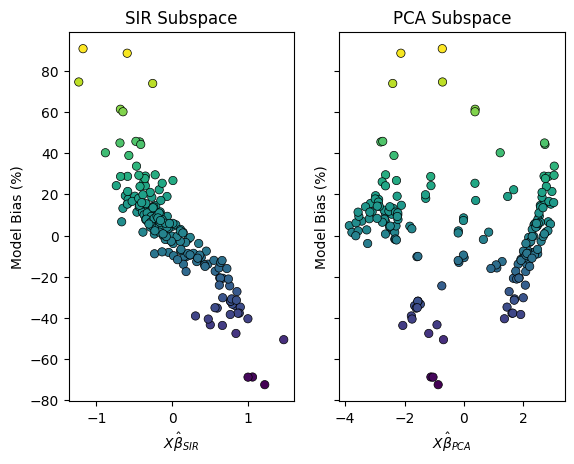

In [ ]:
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

if not hasattr(np, 'int'):
    np.int = int
from sliced import SlicedInverseRegression


# fit SIR model
sir = SlicedInverseRegression().fit(X_scaled, y)
X_sir = sir.transform(X_scaled)

# fit PCA
pca = PCA(random_state=123).fit(X_scaled, y)
X_pca = pca.transform(X_scaled)


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(X_sir[:, 0], y, c=y, cmap='viridis', linewidth=0.5, edgecolor='k')
ax1.set_title('SIR Subspace')
ax1.set_xlabel("$X\hat{\\beta}_{SIR}$")
ax1.set_ylabel("Model Bias (%)")

ax2.scatter(X_pca[:, 0], y, c=y, cmap='viridis', linewidth=0.5, edgecolor='k')
ax2.set_title('PCA Subspace')
ax2.set_xlabel("$X\hat{\\beta}_{PCA}$")
ax2.set_ylabel("Model Bias (%)")

plt.show()

In [5]:
# I don't know what this represents
X_sir.directions_


NameError: name 'X_sir' is not defined